In [2]:
import torch

import numpy as np

import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

# EWMA Meets Gradients

In [61]:
def EWMA(past_value, current_value, alpha):
  return (1- alpha) * past_value + alpha * current_value

def calc_ewma(values, period):
  alpha = 2 / (period + 1)
  result = []
  for v in values:
    try:
      prev_value = result[-1]
    except IndexError:
      prev_value = 0
    new_value = EWMA(prev_value, v, alpha)
    result.append(new_value)
  return np.array(result)

In [62]:
def correction(averaged_value, beta, steps):
  return averaged_value / (1 - (beta ** steps))

def calc_corrected_ewma(values, period):
  ewma = calc_ewma(values, period)
  alpha = 2 / (period + 1)
  beta = 1 - alpha
  result = []
  for step, v in enumerate(ewma):
    adj_value = correction(v, beta, step + 1)
    result.append(adj_value)
  return np.array(result)

In [63]:
temperatures = np.array([5, 11, 15, 6, 5, 3, 3, 0, 0, 3, 4, 2, 1, -1, -2, 2, 2, -2, -1, -1, 3, 4, -1, 2, 6, 4, 9, 11, 9, -2])

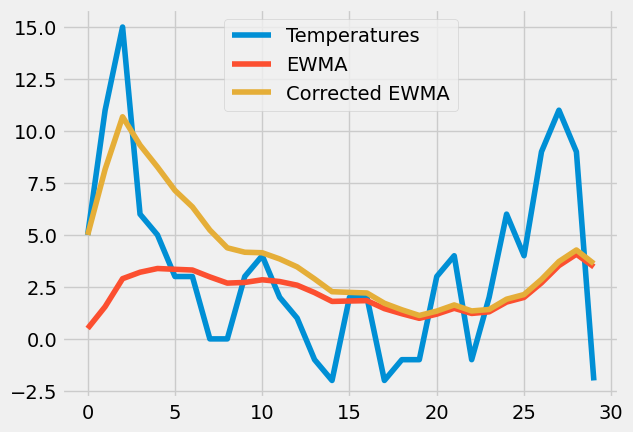

In [64]:
plt.plot(temperatures, label="Temperatures")
plt.plot(calc_ewma(temperatures, 19), label="EWMA")
plt.plot(calc_corrected_ewma(temperatures, 19), label="Corrected EWMA")

plt.legend()

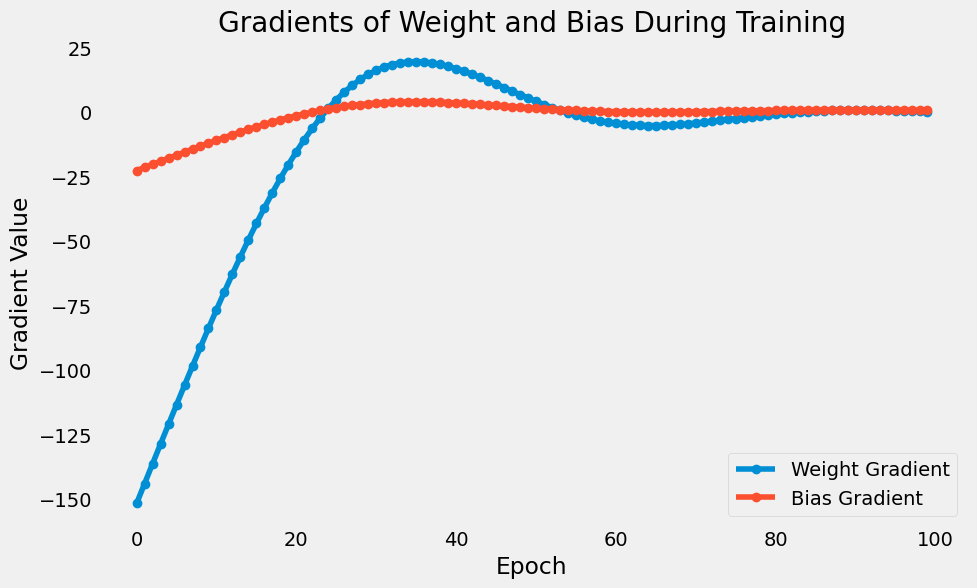

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))

optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss(reduction='mean')

weight_gradients = []
bias_gradients = []

x = np.linspace(0, 10, 100)
y = 3 * x + 1 + np.random.normal(0, 1, size=x.shape)

x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

epochs = 100
losses = []

for epoch in range(epochs):
    predictions = model(x)
    loss = loss_fn(predictions, y)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    weight_gradients.append(model[0].weight.grad.clone().detach().item())
    bias_gradients.append(model[0].bias.grad.clone().detach().item())

    optimizer.step()

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), weight_gradients, label="Weight Gradient", marker='o')
plt.plot(range(epochs), bias_gradients, label="Bias Gradient", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Gradient Value")
plt.title("Gradients of Weight and Bias During Training")
plt.legend()
plt.grid()
plt.show()

# Adam

# Visualizing Adapted Gradients

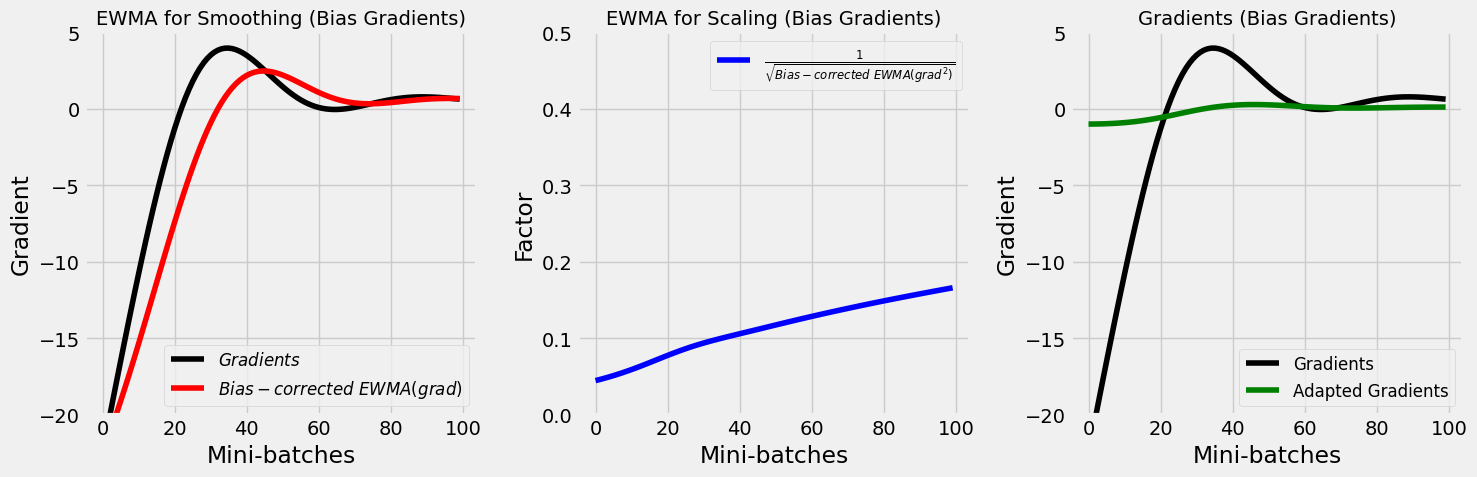

In [66]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss(reduction='mean')

weight_gradients = []
bias_gradients = []

np.random.seed(42)
x = np.linspace(0, 10, 100)
y = 3 * x + 1 + np.random.normal(0, 1, size=x.shape)

x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()

    predictions = model(x)
    loss = loss_fn(predictions, y)

    loss.backward()

    for name, param in model.named_parameters():
        if param.grad is not None:
            if 'bias' in name:
                bias_gradients.append(param.grad.clone().detach().item())
            elif 'weight' in name:
                weight_gradients.append(param.grad.clone().detach().item())

    optimizer.step()

def calc_corrected_ewma(data, beta):
    corrected_ewma = []
    ewma = 0
    for t, value in enumerate(data, 1):
        ewma = beta * ewma + (1 - beta) * value
        corrected_value = ewma / (1 - beta ** t)
        corrected_ewma.append(corrected_value)
    return np.array(corrected_ewma)

bias_gradients = np.array(bias_gradients)
weight_gradients = np.array(weight_gradients)

corrected_bias_gradients = calc_corrected_ewma(bias_gradients, 0.9)
corrected_sq_bias_gradients = calc_corrected_ewma(np.power(bias_gradients, 2), 0.999)
adapted_bias_gradients = corrected_bias_gradients / (np.sqrt(corrected_sq_bias_gradients) + 1e-8)

def figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients, title):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    ax = axs[0]
    ax.plot(gradients, c='k', label=r'$Gradients$')
    ax.plot(corrected_gradients, c='r', linestyle='-', label=r'$Bias-corrected\ EWMA(grad)$')
    ax.set_title(f'EWMA for Smoothing ({title})', fontsize=14)
    ax.set_ylabel('Gradient')
    ax.set_xlabel('Mini-batches')
    ax.set_ylim([-20, 5])
    ax.legend(fontsize=12)

    ax = axs[1]
    ax.plot(1 / (np.sqrt(corrected_sq_gradients) + 1e-8), c='b', linestyle='-', label=r'$\frac{1}{\sqrt{Bias-corrected\ EWMA(grad^2)}}$')
    ax.set_title(f'EWMA for Scaling ({title})', fontsize=14)
    ax.set_ylabel('Factor')
    ax.set_xlabel('Mini-batches')
    ax.set_ylim([0, 0.5])
    ax.legend(fontsize=12)

    ax = axs[2]
    ax.plot(gradients, c='k', label='Gradients')
    ax.plot(adapted_gradients, c='g', label='Adapted Gradients')
    ax.set_title(f'Gradients ({title})', fontsize=14)
    ax.set_ylabel('Gradient')
    ax.set_xlabel('Mini-batches')
    ax.set_ylim([-20, 5])
    ax.legend(fontsize=12)

    fig.tight_layout()
    return fig

figure = figure17(bias_gradients, corrected_bias_gradients, corrected_sq_bias_gradients, adapted_bias_gradients, 'Bias Gradients')
plt.show()

# Stochastic Gradient Descent (SGD)

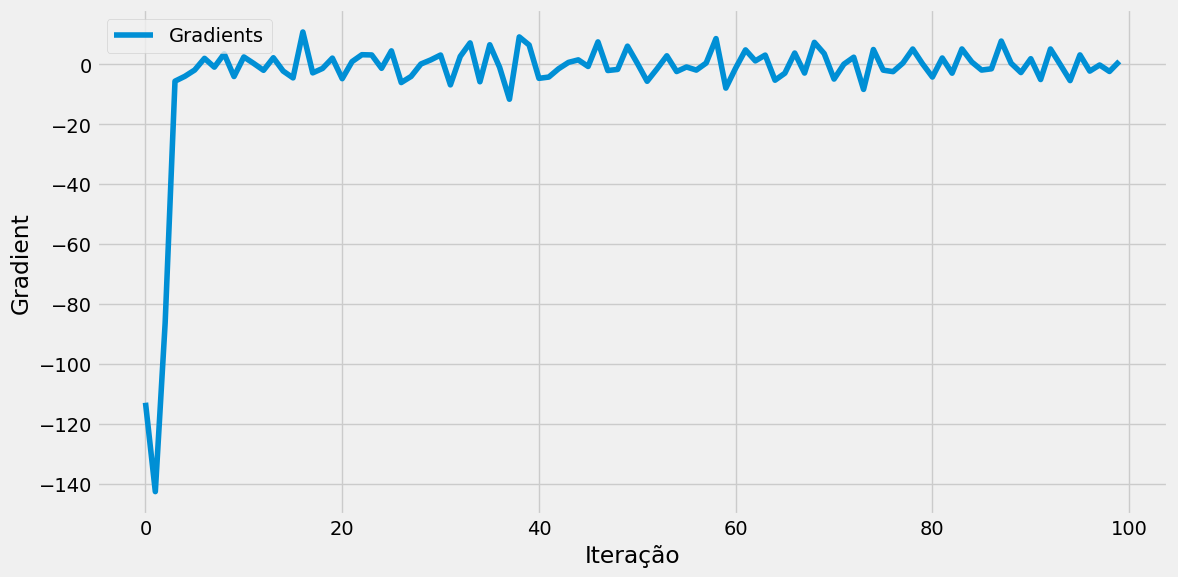

In [67]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
x = np.linspace(0, 10, 100)
y = 2 * x + 1 + np.random.normal(0, 1, size=x.shape)

w = np.random.randn()
b = np.random.randn()

learning_rate = 0.01
num_epochs = 10
batch_size = 10

w_gradients = []
w_values = []

def compute_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

for epoch in range(num_epochs):
    indices = np.random.permutation(len(x))
    x_shuffled = x[indices]
    y_shuffled = y[indices]

    for i in range(0, len(x), batch_size):
        x_batch = x_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]

        y_pred = w * x_batch + b

        dw = -2 * np.mean((y_batch - y_pred) * x_batch)
        db = -2 * np.mean(y_batch - y_pred)

        w -= learning_rate * dw
        b -= learning_rate * db

        w_gradients.append(dw)
        w_values.append(w)

plt.figure(figsize=(12, 6))

plt.plot(w_gradients, label="Gradients")
plt.xlabel("Iteração")
plt.ylabel("Gradient")
plt.legend()

plt.tight_layout()
plt.show()


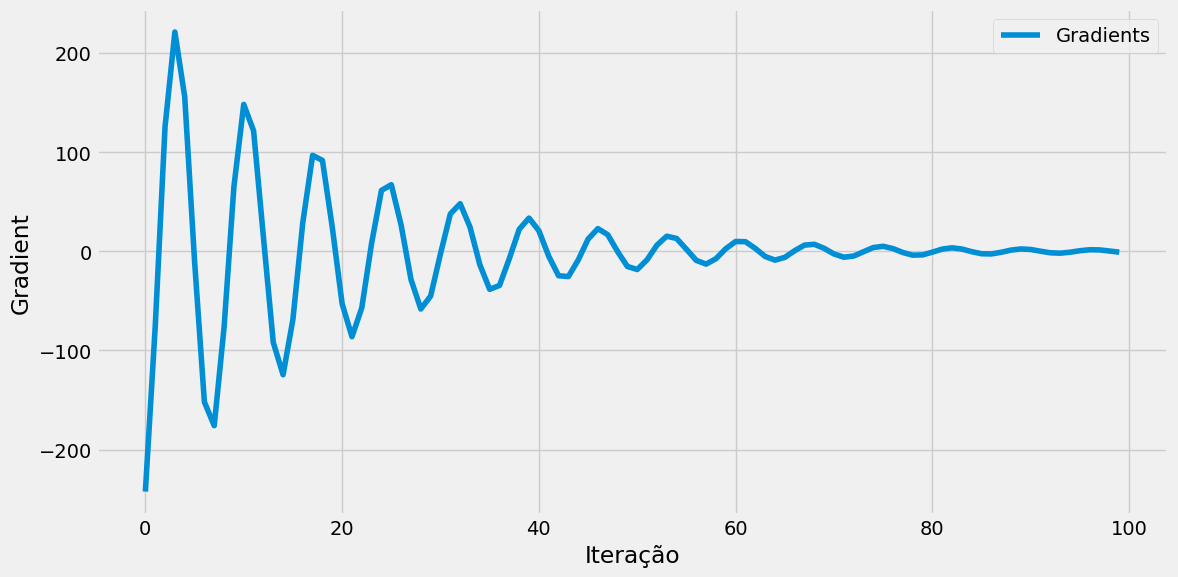

In [68]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
x = np.linspace(0, 10, 100)
y = 2 * x + 1 + np.random.normal(0, 1, size=x.shape)

w = np.random.randn()
b = np.random.randn()

learning_rate = 0.01
momentum = 0.9
num_epochs = 100

v_w = 0
v_b = 0

w_gradients = []
w_values = []

def compute_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

for epoch in range(num_epochs):
    y_pred = w * x + b

    dw = -2 * np.mean((y - y_pred) * x)
    db = -2 * np.mean(y - y_pred)

    v_w = momentum * v_w - learning_rate * dw
    v_b = momentum * v_b - learning_rate * db

    w += v_w
    b += v_b

    w_gradients.append(dw)
    w_values.append(w)

plt.figure(figsize=(12, 6))

plt.plot(w_gradients, label="Gradients")
plt.xlabel("Iteração")
plt.ylabel("Gradient")
plt.legend()


plt.tight_layout()
plt.show()


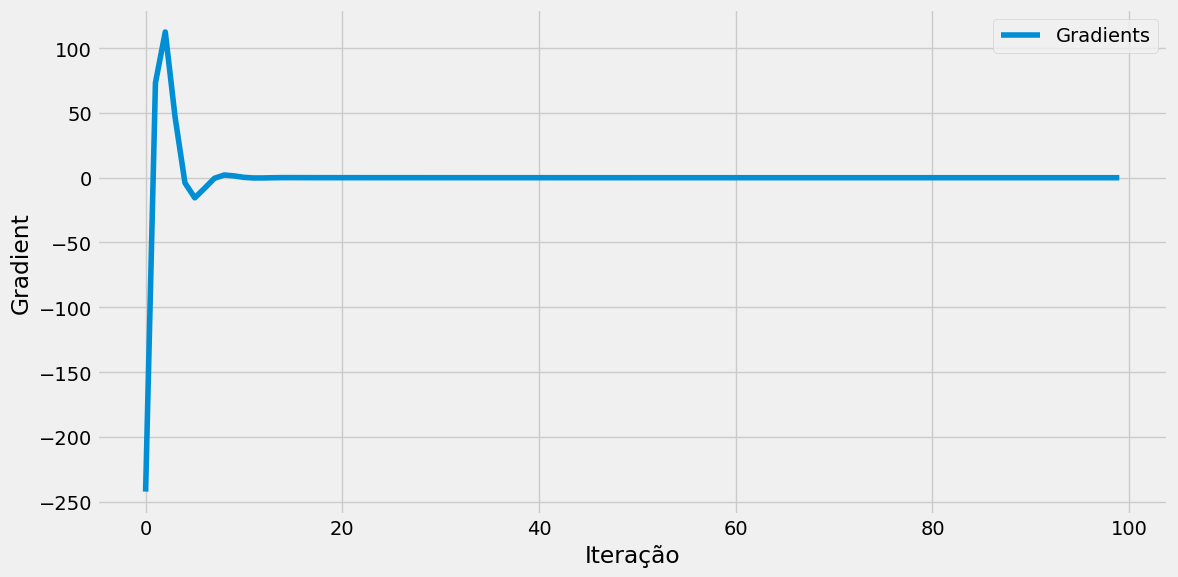

In [69]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
x = np.linspace(0, 10, 100)
y = 2 * x + 1 + np.random.normal(0, 1, size=x.shape)

w = np.random.randn()
b = np.random.randn()

learning_rate = 0.01
momentum = 0.9
num_epochs = 100

v_w = 0
v_b = 0

w_gradients = []
w_values = []

def compute_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

for epoch in range(num_epochs):
    w_ahead = w + momentum * v_w
    b_ahead = b + momentum * v_b

    y_pred = w_ahead * x + b_ahead

    dw = -2 * np.mean((y - y_pred) * x)
    db = -2 * np.mean(y - y_pred)

    v_w = momentum * v_w - learning_rate * dw
    v_b = momentum * v_b - learning_rate * db

    w += v_w
    b += v_b

    w_gradients.append(dw)
    w_values.append(w)

plt.figure(figsize=(12, 6))

plt.plot(w_gradients, label="Gradients")
plt.xlabel("Iteração")
plt.ylabel("Gradient")
plt.legend()

plt.tight_layout()
plt.show()


# Learning Rate Schedulers

351.2942199707031
11995.232421875
410575.03125
14054223.0
481085248.0
16467862528.0
563705806848.0
19296010895360.0
660514698952704.0
2.260985460241203e+16
7.739499456432701e+17
7.676128760168448e+16
7613264397598720.0
755092093403136.0
74890841423872.0
7427755868160.0
736693452800.0
73066086400.0
7246776832.0
718743488.0
71285752.0
61853168.0
53668716.0
46567228.0
40405428.0
35058952.0
30419922.0
26394736.0
22902164.0
19871734.0
17242292.0
17006858.0
16774639.0
16545588.0
16319667.0
16096833.0
15877038.0
15660247.0
15446413.0
15235501.0
15027469.0
15006885.0
14986331.0
14965804.0
14945306.0
14924832.0
14904390.0
14883976.0
14863587.0
14843228.0


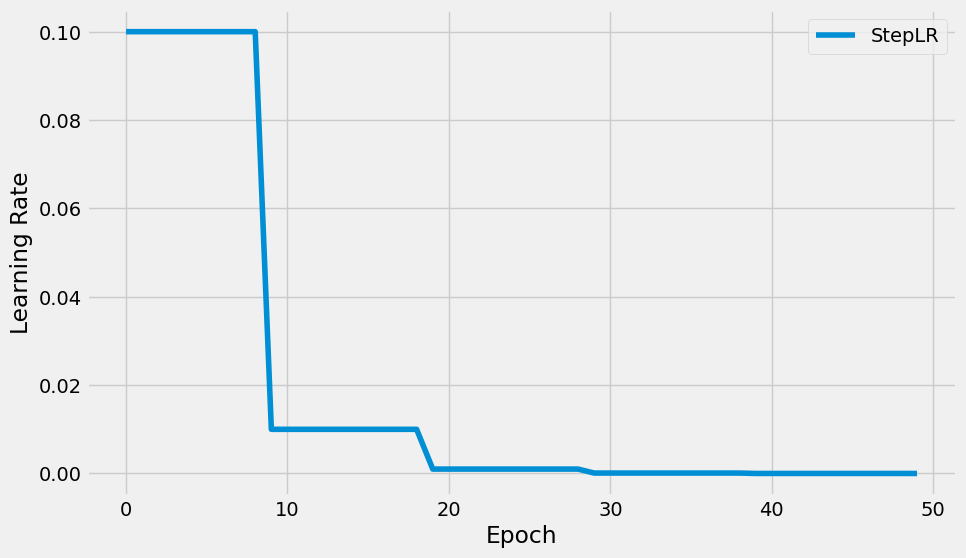

In [70]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

np.random.seed(42)
x = np.linspace(0, 10, 100)
y = 3 * x + 1 + np.random.normal(0, 1, size=x.shape)

x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 50
losses = []
lr_history = []

for epoch in range(num_epochs):
    model.train()

    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step()

    print(loss.item())

    lr_history.append(optimizer.param_groups[0]['lr'])


plt.figure(figsize=(10, 6))
plt.plot(lr_history, label="StepLR")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.show()


371.5714111328125
12691.892578125
338645.71875
7007913.0
111799264.0
1365429120.0
12662524928.0
88302280704.0
457689595904.0
1738580426752.0
4756840906752.0
9173381152768.0
12128024002560.0
10598973702144.0
5825280081920.0
1874214780928.0
315820638208.0
22929231872.0
465627008.0
371674.25
2067.71533203125
58.540164947509766
4.436312198638916
1.2000833749771118
0.8760400414466858
0.8290611505508423
0.8200255632400513
0.8178476691246033
0.8172135949134827
0.8169956207275391
0.8169078230857849
0.8168664574623108
0.8168440461158752
0.8168299794197083
0.8168199062347412
0.8168124556541443
0.816806435585022
0.8168013095855713
0.8167968988418579
0.816792905330658
0.8167898654937744
0.8167868256568909
0.8167840838432312
0.816781759262085
0.8167797923088074
0.8167779445648193
0.8167764544487
0.816774845123291
0.816773533821106
0.8167722225189209


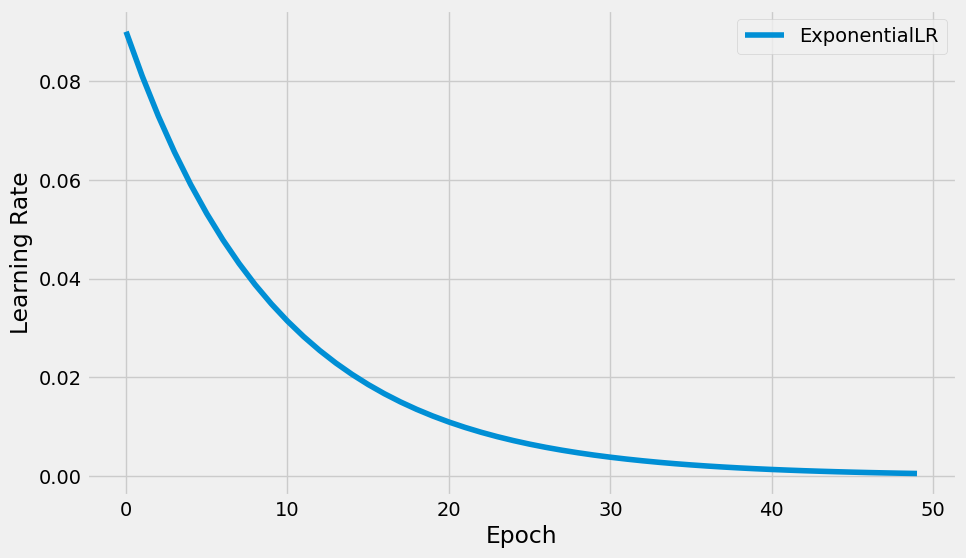

In [71]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

np.random.seed(42)
x = np.linspace(0, 10, 100)
y = 3 * x + 1 + np.random.normal(0, 1, size=x.shape)

x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

num_epochs = 50
losses = []
lr_history = []

for epoch in range(num_epochs):
    model.train()

    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step()

    print(loss.item())

    lr_history.append(optimizer.param_groups[0]['lr'])


plt.figure(figsize=(10, 6))
plt.plot(lr_history, label="ExponentialLR")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.show()


419.818359375
14342.9140625
490939.59375
16805156.0
575251200.0
19691216896.0
674043133952.0
23072939704320.0
135722359062528.0
798361741426688.0
4696218173177856.0
2.762463049993421e+16
1.624967719294075e+17
9.558573412306125e+17
4.854842052837376e+17
2.4657957002149888e+17
1.2523879822000128e+17
6.360928599251354e+16
3.230742045786112e+16
1.6409081468157952e+16
338666861887488.0
6989752041472.0
144261775360.0
2977423360.0
61451188.0
1268295.0
414722.40625
135611.609375
44344.80078125
14501.337890625
4742.7880859375
1551.8265380859375
959.06005859375
592.9290771484375
366.7826232910156
227.09945678710938
140.821533203125
87.53009033203125
54.613162994384766
34.28083801269531
21.721572875976562
13.963438987731934
9.170794486999512
6.209832668304443
4.380225658416748
3.249424934387207
2.5502493381500244
2.1176748275756836
1.8497729301452637
1.683587908744812


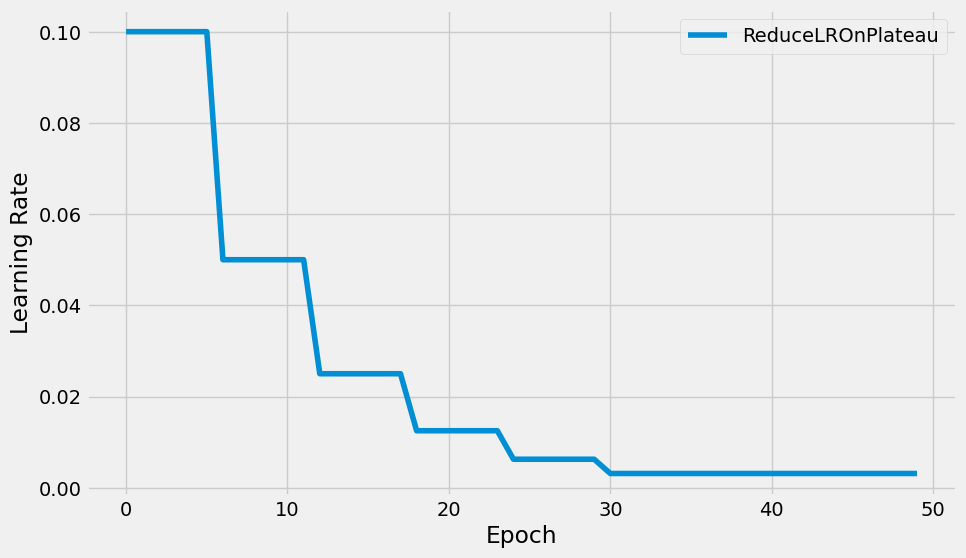

In [72]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

np.random.seed(42)
x = np.linspace(0, 10, 100)
y = 3 * x + 1 + np.random.normal(0, 1, size=x.shape)

x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

num_epochs = 50
losses = []
lr_history = []

for epoch in range(num_epochs):
    model.train()

    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step(loss.item())

    print(loss.item())

    lr_history.append(optimizer.param_groups[0]['lr'])


plt.figure(figsize=(10, 6))
plt.plot(lr_history, label="ReduceLROnPlateau")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.show()


183.58688354492188
37.394744873046875
743.8407592773438
332.4617004394531
4.035454750061035
284.90679931640625
11109.84765625
200213.015625
1321820.75
1168726.375
316094.6875
442.9552917480469
2208030.25
4114276.0
43495328.0
394973952.0
9161626624.0
85296463872.0
631282466816.0
1089283031040.0
684311424.0
156691513344.0
58022813696.0
347450900480.0
1182793465856.0
10893629849600.0
185090793537536.0
1112955949154304.0
363267293708288.0
136846784856064.0
481646893596672.0
117503988596736.0
636725814624256.0
14667702337536.0
538524642181120.0
8447875327459328.0
2.1513455107938714e+17
2.094102908227289e+18
2.6900780334186496e+17
3.239383562935337e+17
4.6470401963432346e+17
7.549359536251863e+17
1.896250463733416e+18
3.0770643793136845e+17
9.114784818251432e+18
1.9712605653502945e+20
7.70402528166609e+21
7.173898237868998e+22
1.4574796812075905e+23
1.0198286127361897e+20
6.474729257598499e+22
1.949062217233869e+22
1.3351329121466075e+23
1.5120016093764259e+22
1.2110923392657705e+23
2.811478

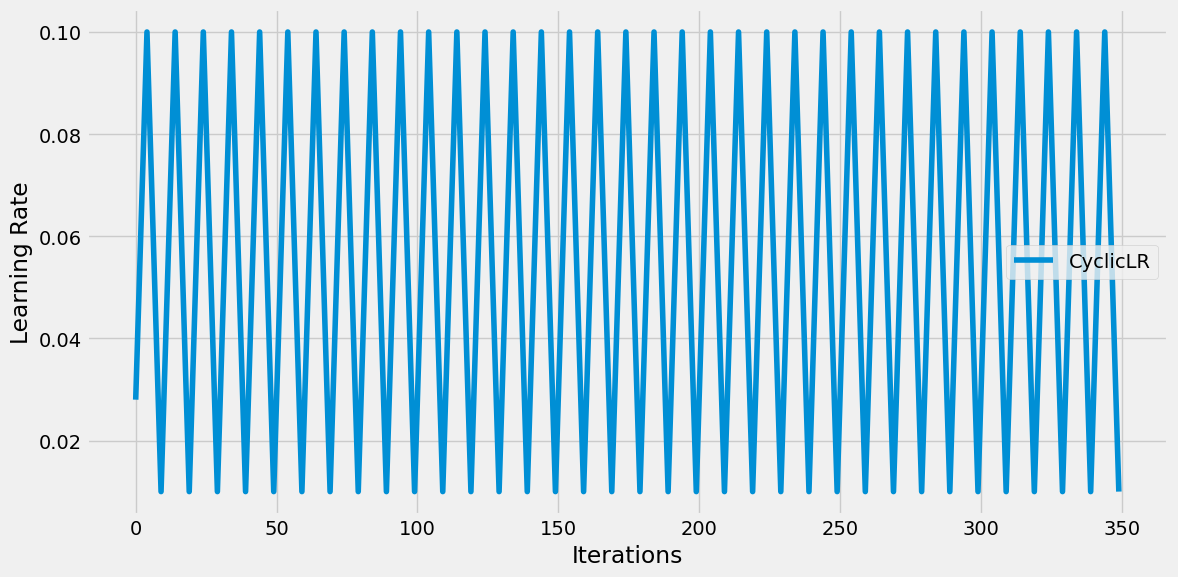

In [73]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

np.random.seed(42)
x = np.linspace(0, 10, 100)
y = 3 * x + 2 + np.random.normal(0, 1, size=x.shape)

x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

batch_size = 16
data = torch.utils.data.TensorDataset(x_train, y_train)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

epochs = 50
model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, step_size_up=5, mode='triangular')

losses = []
lr_history = []

for epoch in range(epochs):
  model.train()

  for batch_x, batch_y in data_loader:
      y_pred = model(batch_x)
      loss = criterion(y_pred, batch_y)
      losses.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      scheduler.step()

      print(loss.item())

      lr_history.append(optimizer.param_groups[0]['lr'])


plt.figure(figsize=(12, 6))

plt.plot(lr_history, label="CyclicLR")
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.legend()

plt.tight_layout()
plt.show()


# Putting It All Together

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [10]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleNN()

In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.999))
loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

epochs = 500

In [31]:
weight_gradients_fc1 = []
bias_gradients_fc1 = []

weight_gradients_fc2 = []
bias_gradients_fc2 = []

In [32]:
for epoch in range(epochs):
    predictions = model(X_train)
    loss = loss_fn(predictions, y_train)

    optimizer.zero_grad()
    loss.backward()

    for name, param in model.named_parameters():
        if param.grad is not None:
            if 'fc1' in name:
                if 'weight' in name:
                    weight_gradients_fc1.append(param.grad.clone().detach().mean().item())
                elif 'bias' in name:
                    bias_gradients_fc1.append(param.grad.clone().detach().mean().item())

            elif 'fc2' in name:
                if 'weight' in name:
                    weight_gradients_fc2.append(param.grad.clone().detach().mean().item())
                elif 'bias' in name:
                    bias_gradients_fc2.append(param.grad.clone().detach().mean().item())

    optimizer.step()

    scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

Epoch [10/500], Loss: 0.0267, Learning Rate: 0.100000
Epoch [20/500], Loss: 0.0202, Learning Rate: 0.010000
Epoch [30/500], Loss: 0.0162, Learning Rate: 0.010000
Epoch [40/500], Loss: 0.0150, Learning Rate: 0.001000
Epoch [50/500], Loss: 0.0148, Learning Rate: 0.001000
Epoch [60/500], Loss: 0.0146, Learning Rate: 0.000100
Epoch [70/500], Loss: 0.0146, Learning Rate: 0.000100
Epoch [80/500], Loss: 0.0145, Learning Rate: 0.000010
Epoch [90/500], Loss: 0.0145, Learning Rate: 0.000010
Epoch [100/500], Loss: 0.0145, Learning Rate: 0.000001
Epoch [110/500], Loss: 0.0145, Learning Rate: 0.000001
Epoch [120/500], Loss: 0.0145, Learning Rate: 0.000000
Epoch [130/500], Loss: 0.0145, Learning Rate: 0.000000
Epoch [140/500], Loss: 0.0145, Learning Rate: 0.000000
Epoch [150/500], Loss: 0.0145, Learning Rate: 0.000000
Epoch [160/500], Loss: 0.0145, Learning Rate: 0.000000
Epoch [170/500], Loss: 0.0145, Learning Rate: 0.000000
Epoch [180/500], Loss: 0.0145, Learning Rate: 0.000000
Epoch [190/500], Lo

In [33]:
def calc_corrected_ewma(data, beta):
    corrected_ewma = []
    ewma = 0
    for t, value in enumerate(data, 1):
        ewma = beta * ewma + (1 - beta) * value
        corrected_value = ewma / (1 - beta ** t)
        corrected_ewma.append(corrected_value)
    return np.array(corrected_ewma)

In [34]:
corrected_weight_gradients_fc1 = calc_corrected_ewma(weight_gradients_fc1, 0.9)
corrected_weight_gradients_fc2 = calc_corrected_ewma(weight_gradients_fc2, 0.9)
corrected_bias_gradients_fc1 = calc_corrected_ewma(bias_gradients_fc1, 0.9)
corrected_bias_gradients_fc2 = calc_corrected_ewma(bias_gradients_fc2, 0.9)

In [35]:
def plot_gradients(gradients, corrected_gradients, title):
    plt.figure(figsize=(10, 5))
    plt.plot(gradients, c='k', label='Gradients')
    plt.plot(corrected_gradients, c='r', linestyle='-', label='Corrected EWMA')
    plt.title(title, fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Gradient')
    plt.legend()
    plt.grid()
    plt.show()

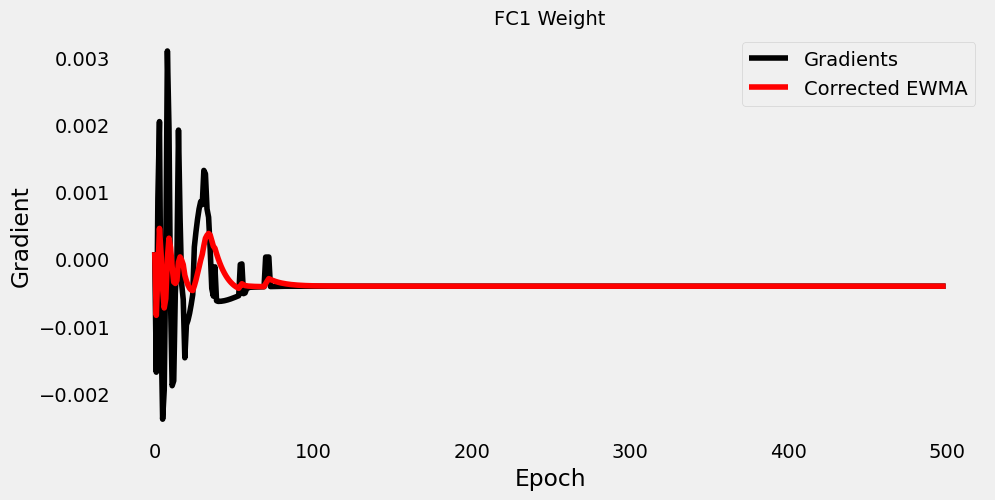

In [36]:
plot_gradients(weight_gradients_fc1, corrected_weight_gradients_fc1, 'FC1 Weight')

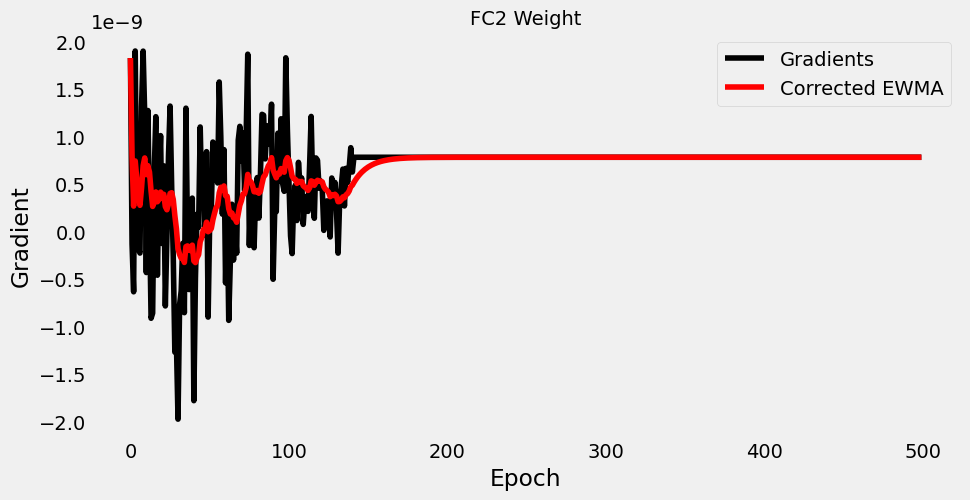

In [37]:
plot_gradients(weight_gradients_fc2, corrected_weight_gradients_fc2, 'FC2 Weight')

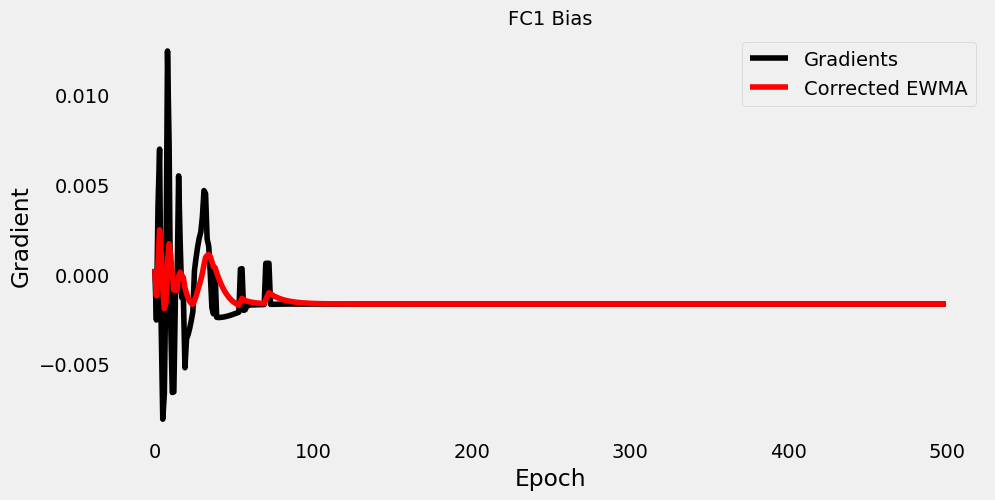

In [38]:
plot_gradients(bias_gradients_fc1, corrected_bias_gradients_fc1, 'FC1 Bias')

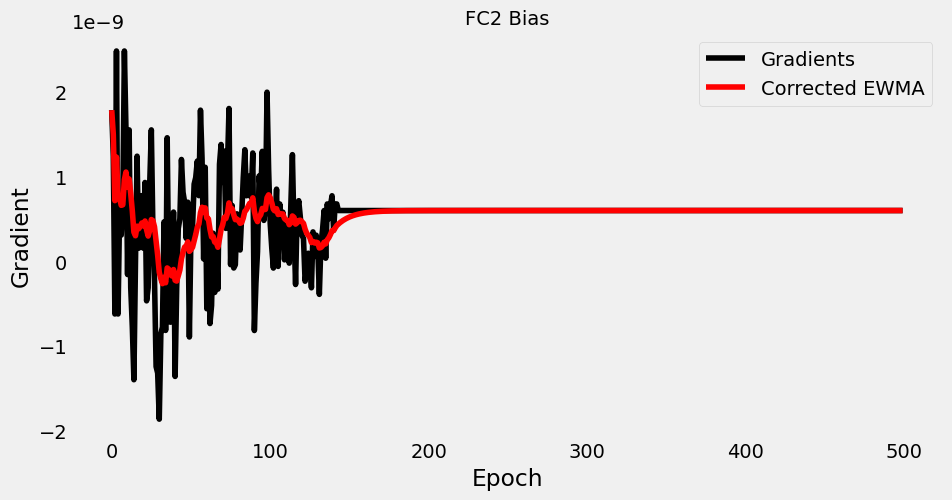

In [39]:
plot_gradients(bias_gradients_fc2, corrected_bias_gradients_fc2, 'FC2 Bias')

In [40]:
model.eval()

with torch.no_grad():
    predictions = model(X_test)
    _, predicted_classes = torch.max(predictions, 1)
    accuracy = (predicted_classes == y_test).float().mean()
    print(f'Acurácia no conjunto de teste: {accuracy.item() * 100:.2f}%')

Acurácia no conjunto de teste: 100.00%
